In [83]:
import numpy as np
import pandas as pd
import pyaldata as pyal
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

from util import prep

In [84]:
# List of sessions
# sessions = ["M052_2025_01_23_15_15", "M052_2025_01_24_15_00", "M052_2025_01_25_14_30", "M052_2025_01_27_15_00"]
sessions = ["M051_2025_02_05_16_00", "M051_2025_02_06_15_00", "M051_2025_02_07_15_30", "M051_2025_02_08_15_30",
            "M051_2025_02_09_16_45", "M051_2025_02_10_16_00","M051_2025_02_11_11_30","M051_2025_02_12_15_30","M051_2025_02_13_15_00"]

data_dir = 'C:/Users/Cecilia/data/raw'
animal = sessions[0][0:4]

# List to store logs for each session
session_logs = []

for session in sessions:
    last_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_last_node.log')
    middle_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_middle_node1.log')
    save_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_save_node.log')
    main = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-Main.log')
    update_buffer = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_buffer.log')
    update_pca = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_pca.log')

    # Combine all DataFrames into one
    logs = pd.concat([last_node, middle_node, save_node, main, update_buffer, update_pca], ignore_index=True)
    logs = logs.sort_values(by='timestamp').reset_index(drop=True)
    #fix timestamp so that it starts with 0
    logs['timestamp'] = logs['timestamp'] - logs['timestamp'][0]   
    
    # Store the session name and logs in the list
    session_logs.append((session, logs))

# # Example usage: Access logs for each session
# for session, logs in session_logs:
#     print(f"Logs for {session}:")
#     display(logs)

In [85]:
# ## Checking the timestamp
# for session, logs in session_logs:
    
#     filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
#     time = filtered_log['timestamp']

#     plt.hist(np.diff(time),bins=100)
#     print(any(np.diff(time)<0))
#     print(np.min(np.diff(time)))

In [86]:
ccs

[array([1.]),
 array([1.        , 0.99999979]),
 array([1.        , 1.        , 0.99992346]),
 array([1.        , 1.        , 1.        , 0.99516448]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.25862569]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.59339532, 0.18851354]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.87938468, 0.47129913, 0.33626667]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.91482892, 0.65115599, 0.49604106, 0.25033357]),
 array([1.        , 1.        

In [87]:
cursor_all = []
cursor_avg_all = []
time_cursor_all = []
time_cursor_avg_all = []
bci_value_all = []
rewarded_bci_value_all = []
th_value_all = []
time_th_value_all = []
ccs_all = []

for session, logs in session_logs:

    filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
    cursor = filtered_log['message'].str.extract(r'rolling cca sum=([0-9\.]+)')
    cursor = pd.to_numeric(cursor[0], errors='coerce')
    time_cursor = np.array(filtered_log['timestamp'])
    
    
    filtered_log = logs[logs['message'].str.contains('rolling cca sum=', na=False)]
    ccs = filtered_log['message'].str.extract(r'\[([^\]]+)\]')[0]
    ccs = [np.array(row.split(), dtype=float) for row in ccs.dropna()] 
    ccs_num =10
    ccs = np.array([np.pad(arr, (0, ccs_num - len(arr)), mode='constant', constant_values=1)
                         if len(arr) < ccs_num else arr[:ccs_num] for arr in ccs])

    filtered_log = logs[logs['message'].str.contains(r'cursor value')]
    bci_change_value = filtered_log['message'].str.extract(r'(\d)$')
    bci_change_value = np.array(pd.to_numeric(bci_change_value[0], errors='coerce'))
    time_bci_change = filtered_log['timestamp']
    # Fix the bci values to be in each sample
    idx = np.searchsorted(time_bci_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    bci_value = np.where(idx < 0, 1 - bci_change_value[0], bci_change_value[idx]) # If idx is -1 (before first change), set to the opposite of the first change

    filtered_log = logs[logs['message'].str.contains(r'Node2 PCA matrix/CCA threshold updated:')]
    th_change_value = filtered_log['message'].str.extract(r'new th=([0-9\.]+)')
    th_change_value = np.array(pd.to_numeric(th_change_value[0], errors='coerce'))
    time_th_change = filtered_log['timestamp']    
    # Fix the th values to be in each sample
    idx = np.searchsorted(time_th_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    th_value = np.where(idx < 0, th_change_value[0], th_change_value[idx]) # If idx is -1 (before first change), set first th value

    window_size = 100
    cursor_avg = np.convolve(cursor, np.ones(window_size)/window_size, mode='valid')
    time_cursor_avg = time_cursor[int(window_size/2-1):int(len(time_cursor)-window_size/2)]

    # Rewarded intervals
    n_rewarded_samples = 5 # 200ms
    diff = np.diff(bci_value)
    start_indices = np.where(diff == 1)[0] + 1
    end_indices = np.where(diff == -1)[0] + 1
    if bci_value[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if bci_value[-1] == 1:
        end_indices = np.append(end_indices, len(bci_value))
    mask = np.zeros_like(bci_value, dtype=bool)
    for start, end in zip(start_indices, end_indices):
        if end - start >= n_rewarded_samples:
            mask[start:end] = True
    rewarded_bci_value = np.where(mask, bci_value, 0)
    
    cursor_all.append(cursor)
    cursor_avg_all.append(cursor_avg)
    time_cursor_all.append(time_cursor)
    time_cursor_avg_all.append(time_cursor_avg)
    bci_value_all.append(bci_value)
    rewarded_bci_value_all.append(rewarded_bci_value)
    th_value_all.append(th_value)
    ccs_all.append(ccs)

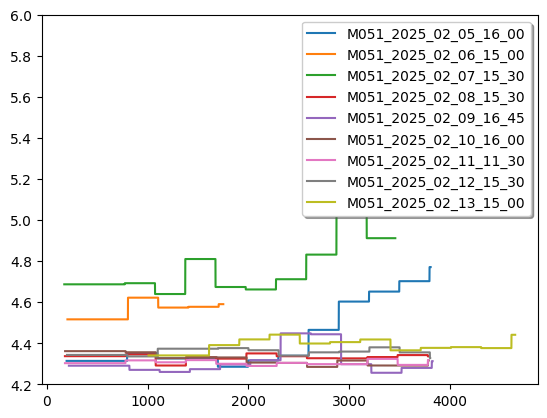

In [19]:
for session in range(len(sessions)):
    plt.plot(time_cursor_all[session],th_value_all[session], label=sessions[session])
    legend = plt.legend(loc='upper right', shadow=True)
    
    plt.ylim(4.2,6)

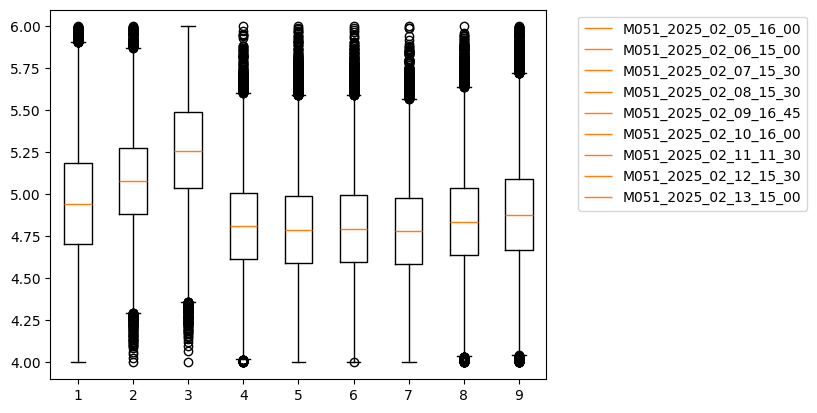

In [20]:
filtered_cursor_all = [session[(session >= 4) & (session <= 6)] for session in cursor_all]

plt.boxplot(filtered_cursor_all, label=sessions)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

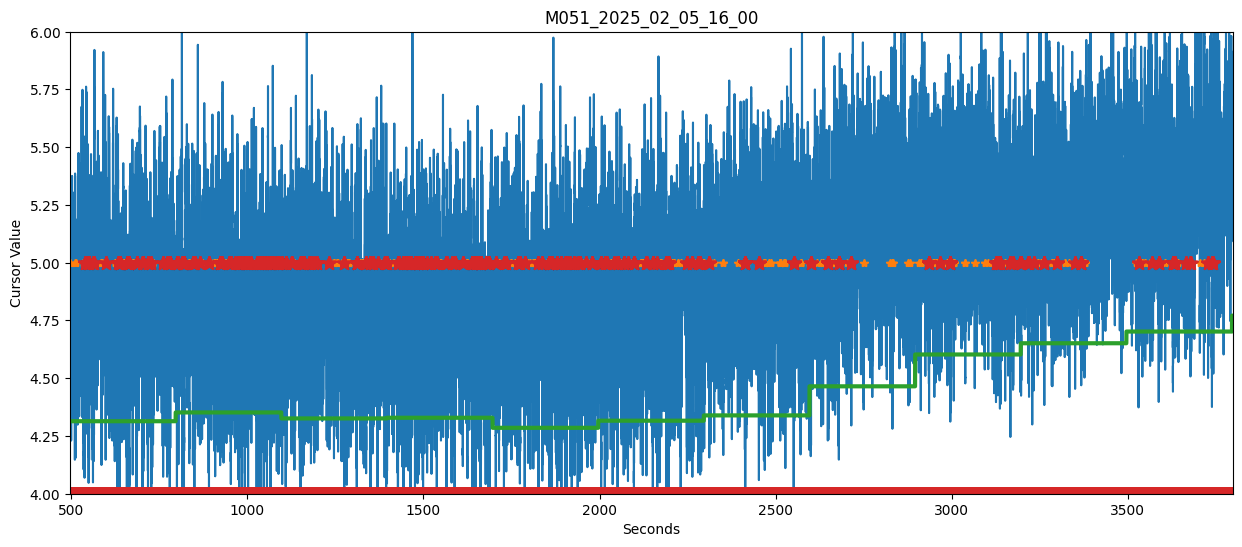

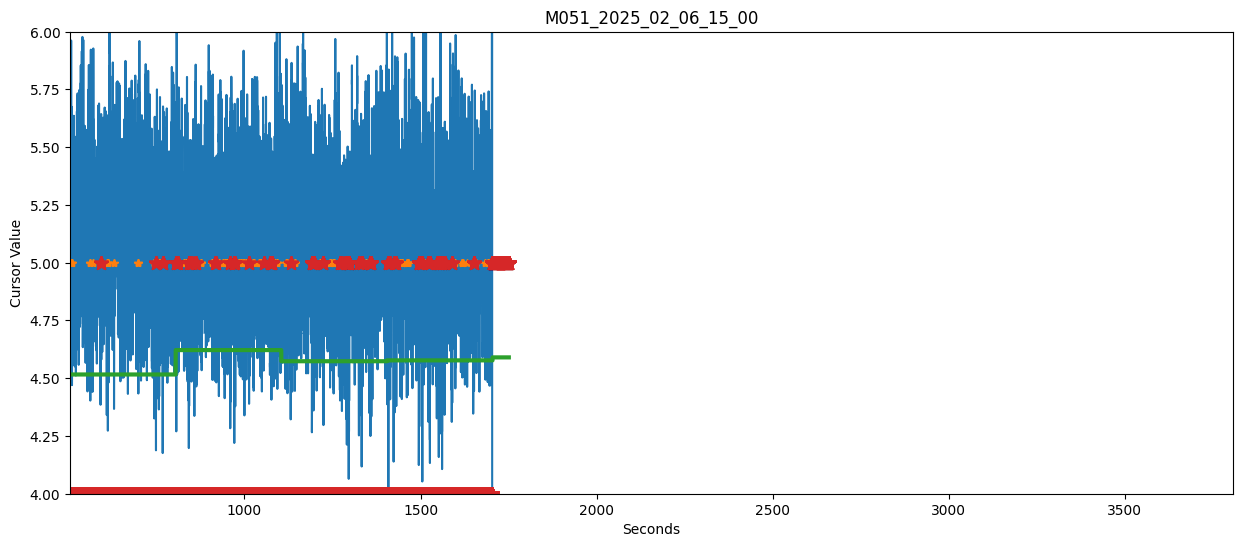

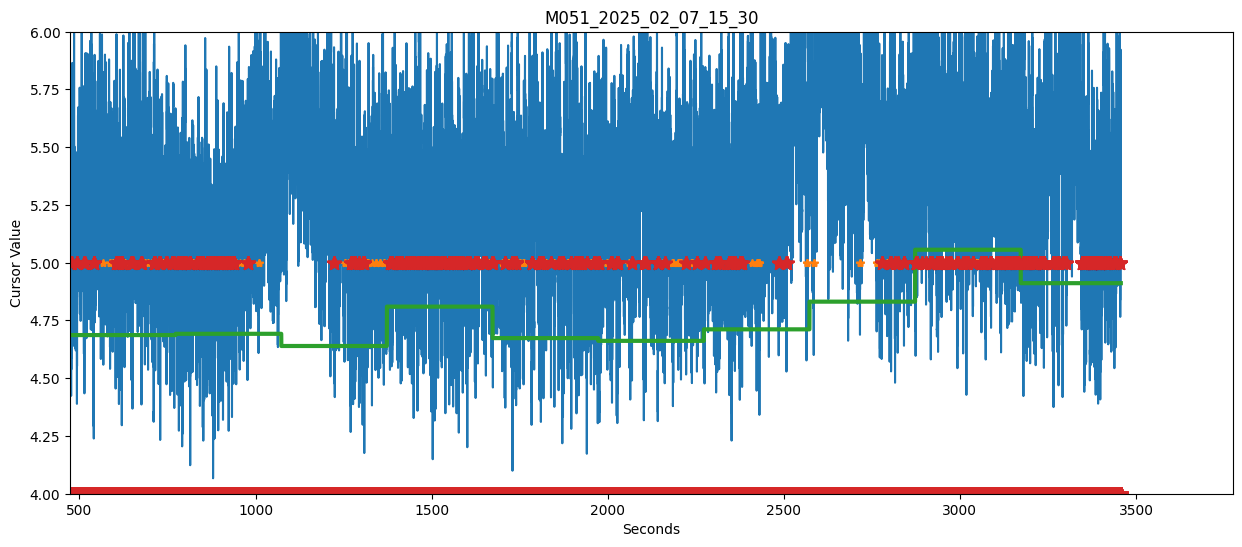

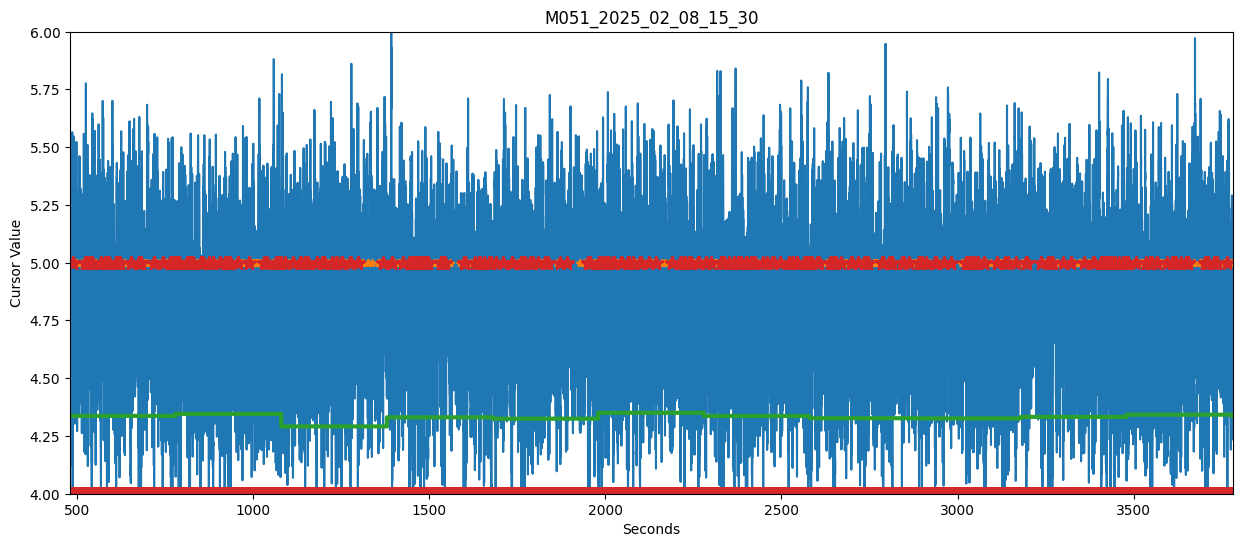

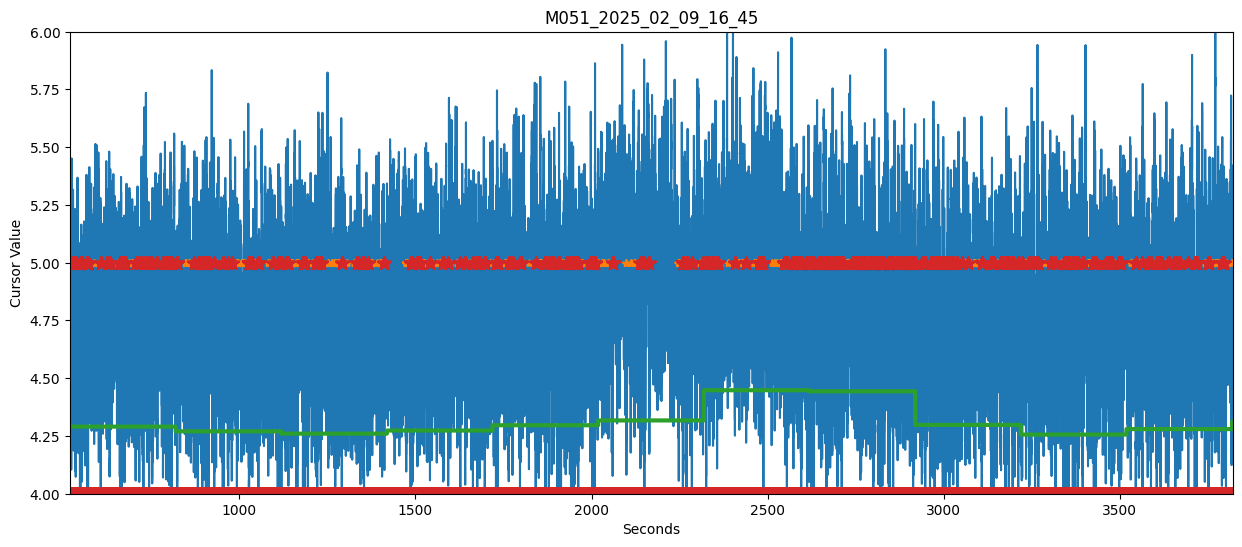

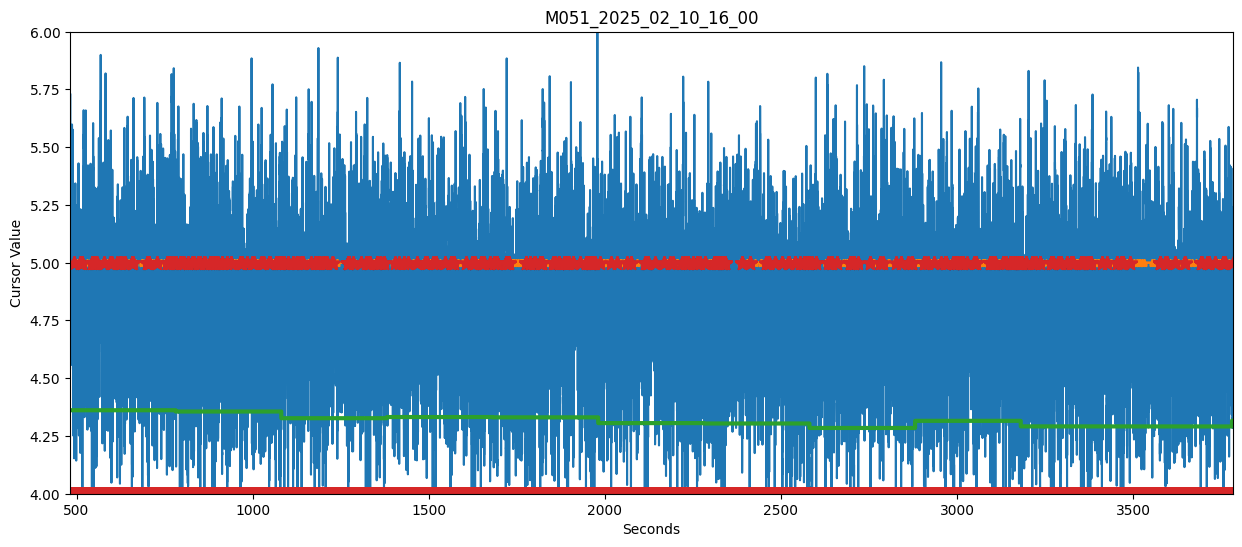

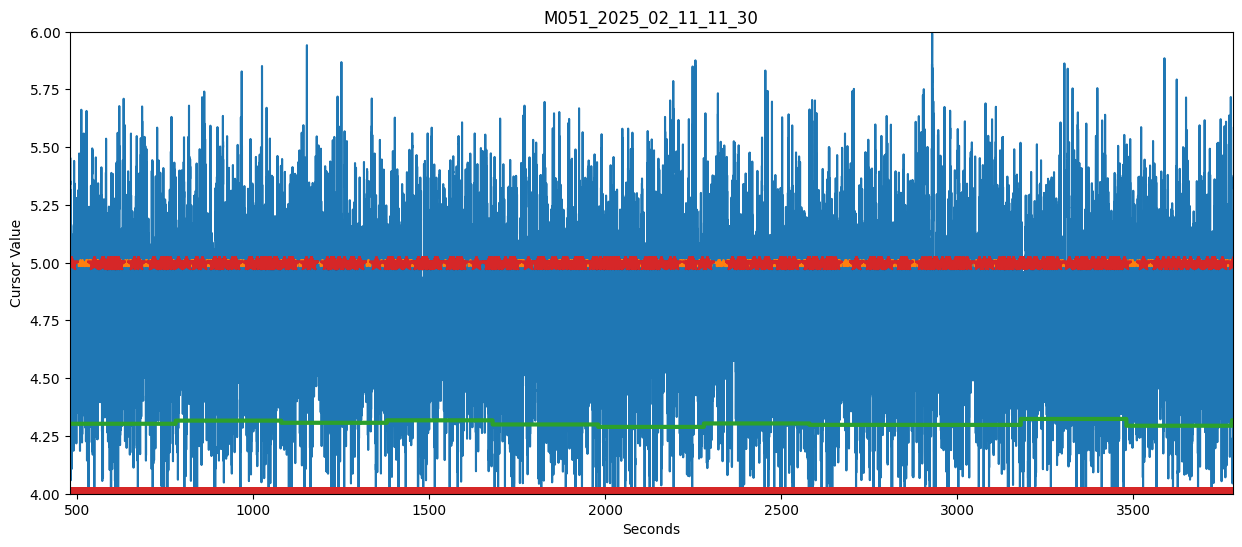

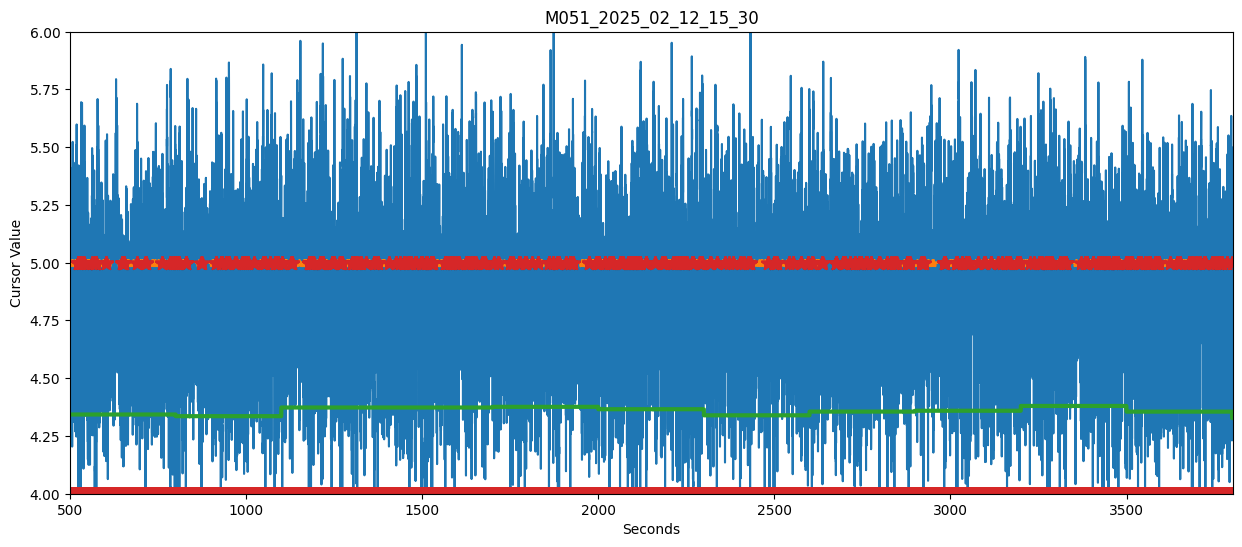

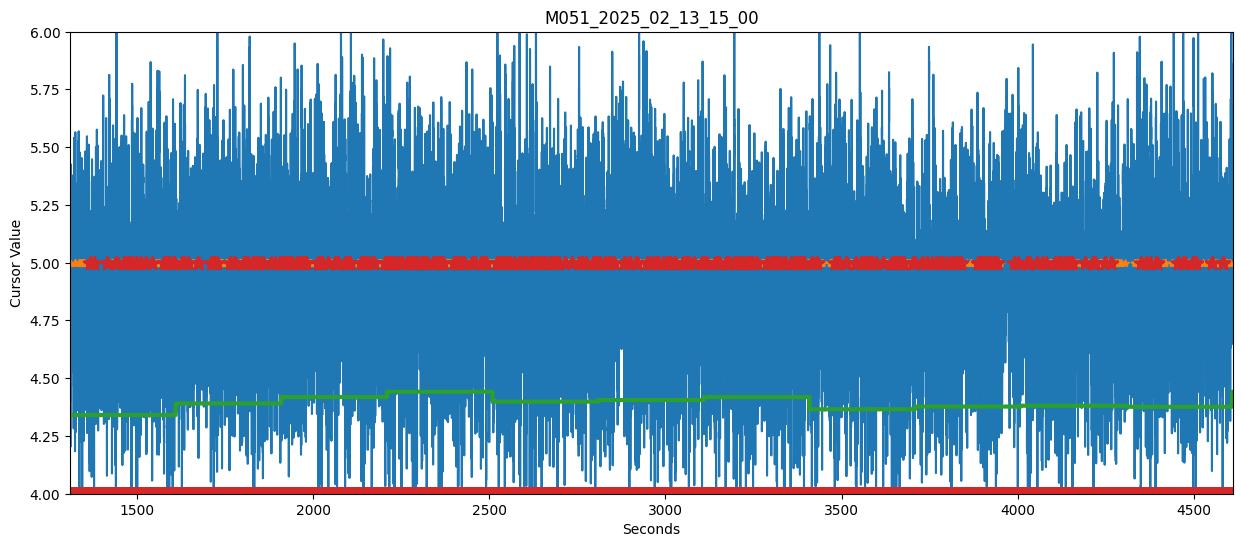

In [21]:
# Plot the cursor values
for session in range(len(session_logs)):
    min = time_cursor_all[session][0] + 300
    max = time_cursor_all[session][0] + 3601
    plt.figure(figsize=(15, 6))
    plt.plot(time_cursor_all[session], cursor_all[session])
    plt.plot(time_cursor_all[session], bci_value_all[session] + 4, '*')
    plt.plot(time_cursor_all[session], th_value_all[session], linewidth=3) 
    # plt.plot(time_cursor_avg, cursor_avg, linewidth=2)
    plt.plot(time_cursor_all[session], rewarded_bci_value_all[session] + 4, '*', markersize=10)

    plt.title(session_logs[session][0])
    plt.xlabel('Seconds')
    plt.ylabel('Cursor Value')
    # Set x-axis limits
    plt.xlim(min, max)
    plt.ylim(4, 6)

    plt.show()

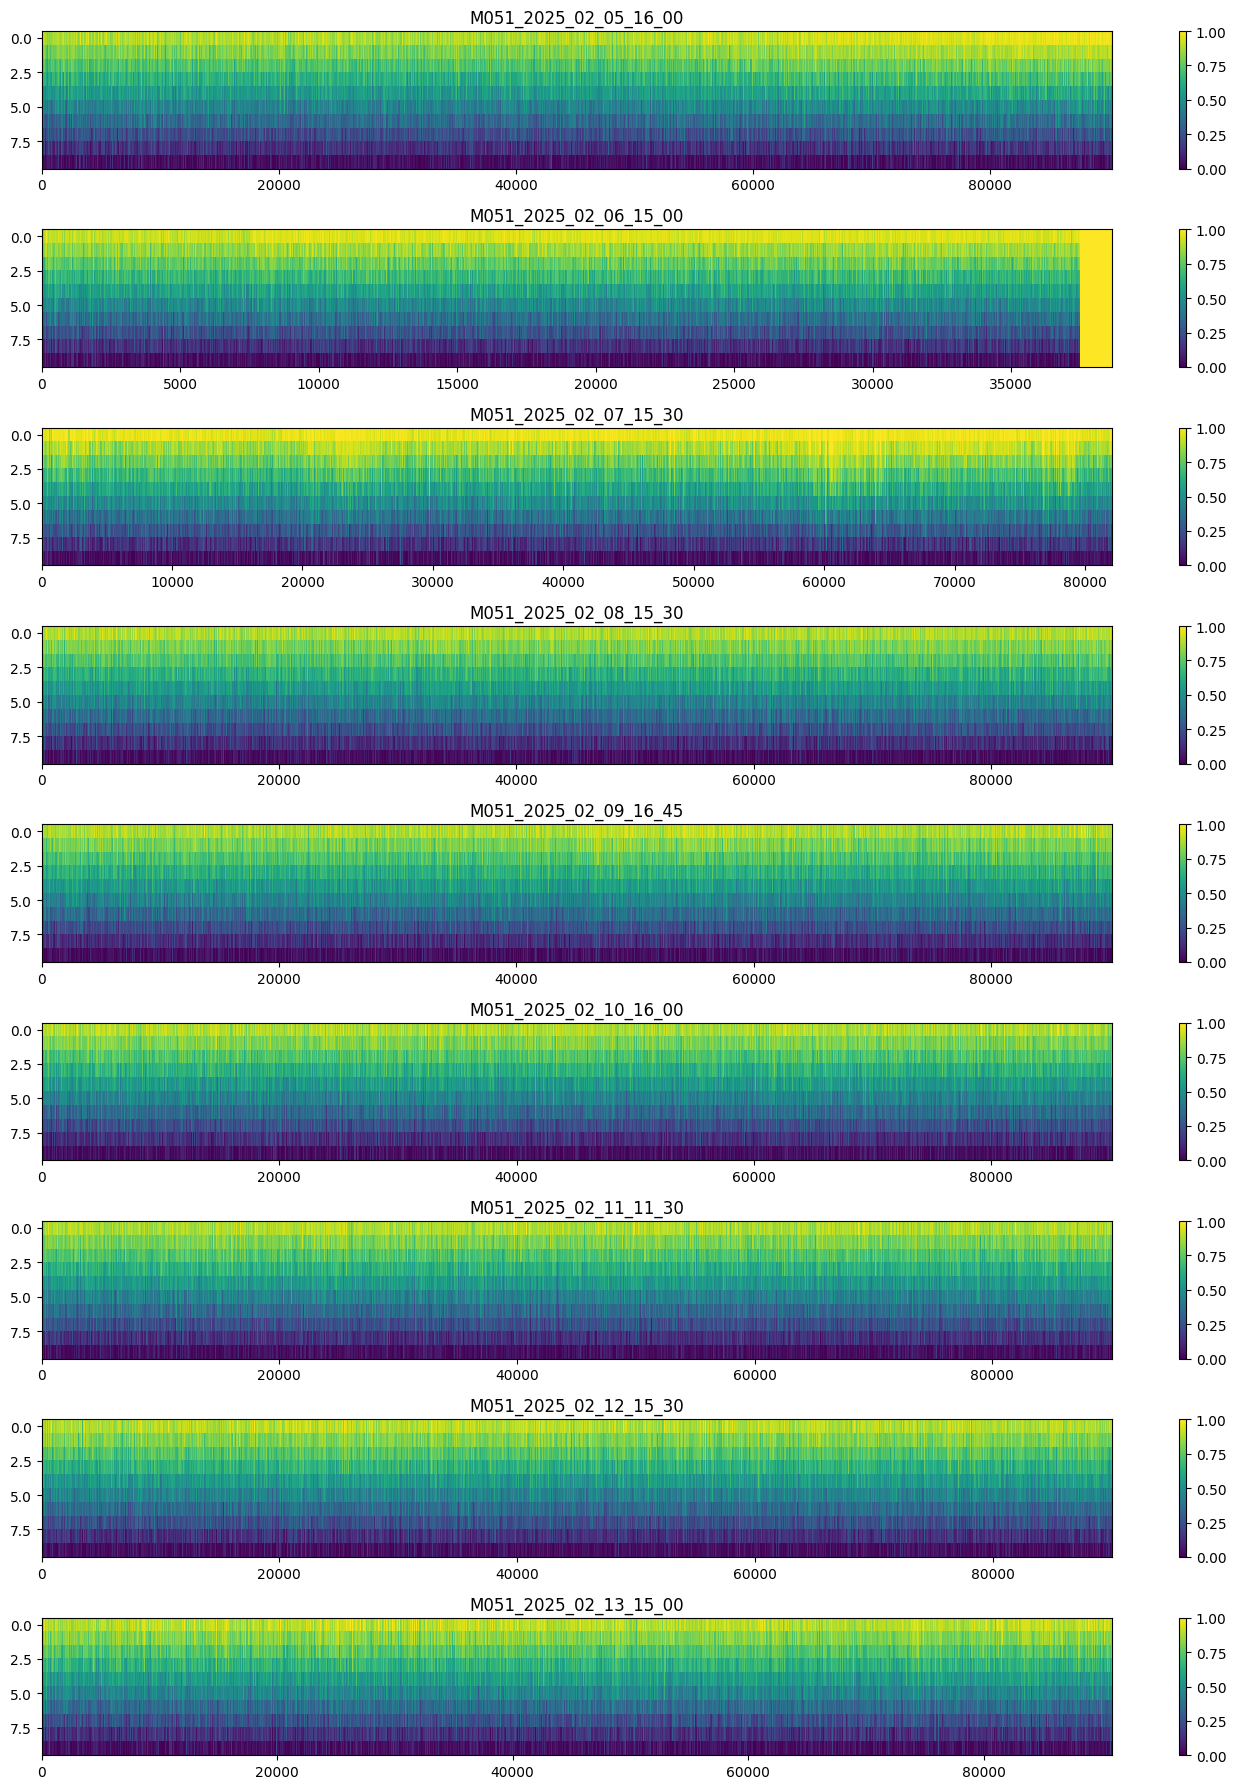

In [107]:
fig, ax = plt.subplots(len(session_logs), 1, figsize=(14, len(session_logs)*2))

# Plot the cursor values
for session in range(len(session_logs)):
    min = time_cursor_all[session][0] + 300
    max = time_cursor_all[session][0] + 3601
    # ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest')
    im = ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[session].set_title(session_logs[session][0])
    fig.colorbar(im, ax=ax[session])

# plt.ylabel('ccs')
plt.tight_layout() 
plt.show()

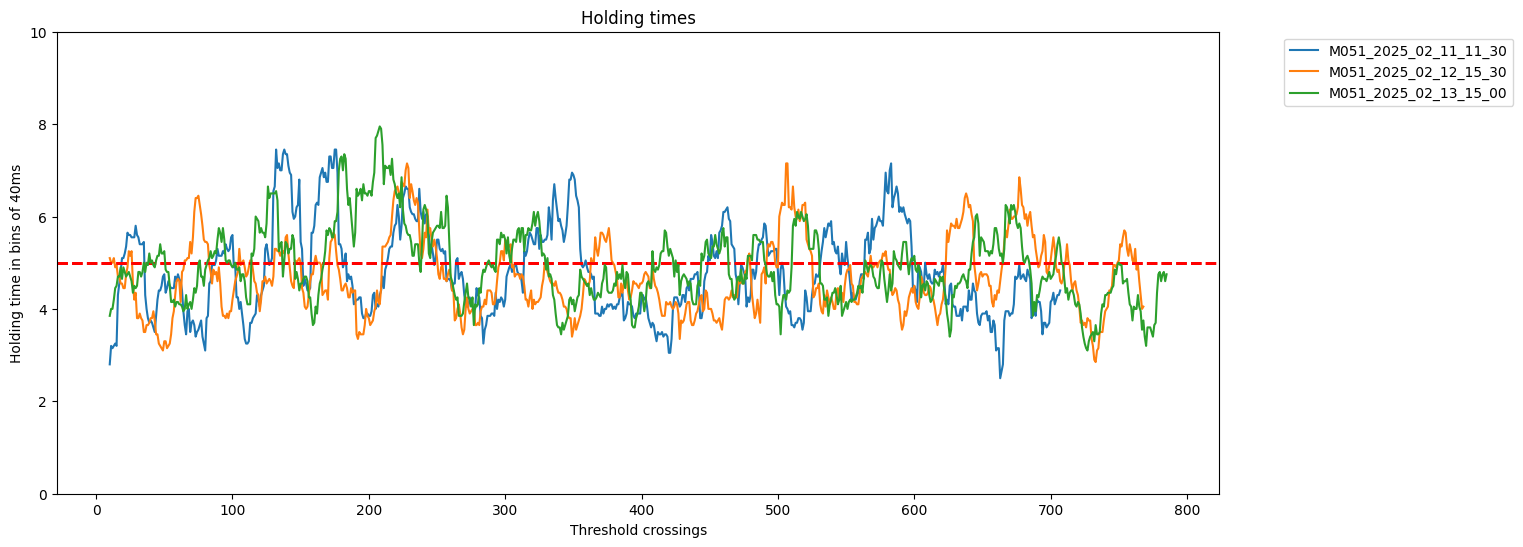

In [33]:
window_size = 20
plt.figure(figsize=(15, 6))
    
# Plot the cursor values
for session in range(len(session_logs)):
    if session < 6:
        continue
    bci_value = bci_value_all[session]

    # Find the start and end indices of groups of 1s
    diff = np.diff(bci_value)
    start_indices = np.where(diff == 1)[0] + 1
    end_indices = np.where(diff == -1)[0] + 1

    # Handle the case where the array starts or ends with a group of 1s
    if bci_value[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if bci_value[-1] == 1:
        end_indices = np.append(end_indices, len(bci_value))

    # Calculate the number of 1s in each group
    group_lengths = end_indices - start_indices

    # plt.plot(group_lengths, label = session_logs[session][0])
    plt.axhline(y=5, color='r', linestyle='--', linewidth=2)
    plt.plot(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size+1),np.convolve(group_lengths, np.ones(window_size)/window_size, mode='valid'), label = session_logs[session][0])

plt.ylim(0,10)
plt.title('Holding times')
plt.xlabel('Threshold crossings')
plt.ylabel('Holding time in bins of 40ms')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
filtered_cursor_all = [session[(session >= 4) & (session <= 6)] for session in cursor_all]

plt.boxplot(filtered_cursor_all, label=sessions)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0, 0.5, 'Time bins holded (40ms time bins)')

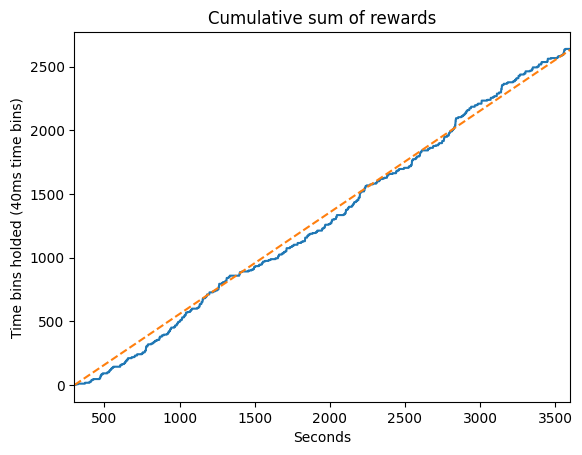

In [14]:
min = 300
max = 3601
y_reference = np.linspace(np.cumsum(rewarded_bci_value).min(), np.cumsum(rewarded_bci_value).max(), len(rewarded_bci_value)-7500)
plt.plot(time_bci_value,np.cumsum(rewarded_bci_value))
plt.plot(time_bci_value[7500:], y_reference, '--')
plt.xlim(min, max)

# y_reference = np.linspace(np.cumsum(bci_value).min(), np.cumsum(bci_value).max(), len(bci_value)-7500)
# plt.plot(time_bci_value,np.cumsum(bci_value))
# plt.plot(time_bci_value[7500:], y_reference, '--')
# plt.xlim(min, max)

plt.title('Cumulative sum of rewards')
plt.xlabel('Seconds')
plt.ylabel('Time bins holded (40ms time bins)')

Text(0, 0.5, 'Threshold crossings')

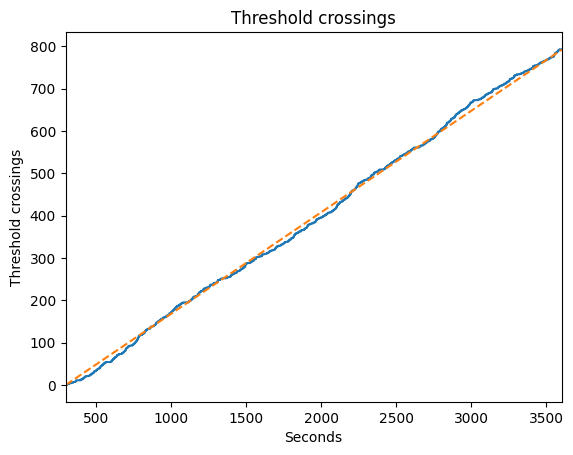

In [15]:
min = 300
max = 3601

diff = np.diff(bci_value) > 0 # Changes from 0 to 1
y_reference = np.linspace(np.cumsum(diff).min(), np.cumsum(diff).max(), len(diff)-7500)

plt.plot(time_bci_value[:-1], np.cumsum(diff))
plt.plot(time_bci_value[7500:-1], y_reference, '--')
plt.xlim(min, max)
plt.title('Threshold crossings')
plt.xlabel('Seconds')
plt.ylabel('Threshold crossings')

Holding times!

Text(0, 0.5, 'Holding time in bins of 40ms')

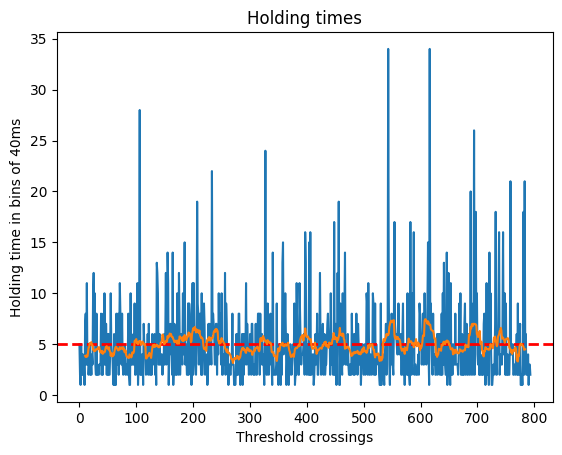

In [26]:
# Find the start and end indices of groups of 1s
diff = np.diff(bci_value)
start_indices = np.where(diff == 1)[0] + 1
end_indices = np.where(diff == -1)[0] + 1

# Handle the case where the array starts or ends with a group of 1s
if bci_value[0] == 1:
    start_indices = np.insert(start_indices, 0, 0)
if bci_value[-1] == 1:
    end_indices = np.append(end_indices, len(bci_value))

# Calculate the number of 1s in each group
group_lengths = end_indices - start_indices


plt.plot(group_lengths)
plt.axhline(y=5, color='r', linestyle='--', linewidth=2)
window_size = 20
plt.plot(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size+1),np.convolve(group_lengths, np.ones(window_size)/window_size, mode='valid'))

plt.title('Holding times')
plt.xlabel('Threshold crossings')
plt.ylabel('Holding time in bins of 40ms')


In [20]:
len(group_lengths)-window_size/2

744.0

In [22]:
print(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size))

[ 50.          51.001443    52.002886    53.004329    54.00577201
  55.00721501  56.00865801  57.01010101  58.01154401  59.01298701
  60.01443001  61.01587302  62.01731602  63.01875902  64.02020202
  65.02164502  66.02308802  67.02453102  68.02597403  69.02741703
  70.02886003  71.03030303  72.03174603  73.03318903  74.03463203
  75.03607504  76.03751804  77.03896104  78.04040404  79.04184704
  80.04329004  81.04473304  82.04617605  83.04761905  84.04906205
  85.05050505  86.05194805  87.05339105  88.05483405  89.05627706
  90.05772006  91.05916306  92.06060606  93.06204906  94.06349206
  95.06493506  96.06637807  97.06782107  98.06926407  99.07070707
 100.07215007 101.07359307 102.07503608 103.07647908 104.07792208
 105.07936508 106.08080808 107.08225108 108.08369408 109.08513709
 110.08658009 111.08802309 112.08946609 113.09090909 114.09235209
 115.09379509 116.0952381  117.0966811  118.0981241  119.0995671
 120.1010101  121.1024531  122.1038961  123.10533911 124.10678211
 125.108225

Compare first and second half of the recordings
